# 2D Auto Measurement

### Setup

In [1]:
%cd hmr2//src
from utils import *

f:\Projects\Body Measurement\Current\hmr2\src
C:\Users\Sathiya\miniconda3\envs\TensorFlow-GPU\python.exe 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]


In [3]:
# import urllib.request
# url = 'https://github.com/russoale/hmr2.0/releases/download/2.0/base_model.paired.zip'
# filename = '..\\..\\logs\\paired\\base_model.paired.zip'
# urllib.request.urlretrieve(url, filename)
# from zipfile import ZipFile
# with ZipFile('..\\..\\logs\\paired\\base_model.paired.zip', 'r') as zipObj:
#    zipObj.extractall('..\\..\\logs\\paired\\')

In [17]:
## Parameters ##
front_img_dir = "..\\..\\in\\front.jpg"
side_img_dir = "..\\..\\in\\side.jpg"
ht = 180

ht_factor = 5 # percentage of pixels to detect top of segmentation in the mask
neck_shift_factor = 0.025 # shifting neck point upward from models predicted point
waist_shift_factor = 0.04 # shifting hip point upward from models predicted point
arm_scale = 0.95 
ht_scale = 1.04
wrist_factor = 2.2

In [3]:
## Loading Models ##
seg_model = segmentation_model()
hmr_model = HMRmodel()
## Renderer ## - optional
from visualise.trimesh_renderer import TrimeshRenderer
renderer = TrimeshRenderer()

model loaded successfully!
Saving logs to f:\Projects\Body Measurement\Current\logs\paired\base_model

Configurations:
BATCH_SIZE                     1
CUSTOM_REGRESSOR_IDX           {0: 'regressor_test.npy'}
CUSTOM_REGRESSOR_PATH          f:\Projects\Body Measurement\Current\hmr2\src\tests\files\regressors
DATASETS                       ['dataset']
DATA_DIR                       f:\Projects\Body Measurement\Current\hmr2\src\tests\files
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
DS_KP2D                        {'lsp': 14, 'cocoplus': 19, 'custom': 21}
DS_KP3D                        {'lsp': 14, 'cocoplus': 14, 'custom': 16}
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_ONLY                   True
EPOCHS                         55
GENERATOR_2D_LOSS_WEIGHT       60.0
GENERATOR_3D_LOSS_WEIGHT       60.0
GENERATOR_LEARNING_RATE        1e-05
GENERATOR_WEIGHT_DECAY         0.0001
INITIALIZE_CUSTOM_REGRESSOR    False
ITERA

### Front View

In [4]:
front_image = Image.open(front_img_dir)
res_im,seg_f=seg_model.run(front_image)
mask_f, bg_removed_f = bg_removal(front_image, seg_f)

In [5]:
ori_f, inp_f, param_f = preprocess_image("..\\..\\out\\bg_rem_img.jpg",224)
joints_f, vertices_f, cams_f = hmr(inp_f, hmr_model)

Resizing image to 224
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [8]:
# mesh = renderer.mesh(vertices_f[0])
# mesh.show()
# visualize(renderer, np.array(front_image), param_f, vertices_f[0], cams_f[0], joints_f[0])

    0: Right ankle
    1: Right knee
    2: Right hip
    3: Left hip
    4: Left knee
    5: Left ankle
    6: Right wrist
    7: Right elbow
    8: Right shoulder
    9: Left shoulder
    10: Left elbow
    11: Left wrist
    12: Neck
    13: Head top
    14: nose
    15: left_eye
    16: right_eye
    17: left_ear
    18: right_ear

In [6]:
joints_f = joints_f[0]
img_f, joints_f = convert_to_int(inp_f, joints_f)

In [7]:
mask_scaled_f = preprocess_gray(mask_f)
top_f, bottom_f  = ht_pts(mask_scaled_f,ht_factor)
ht_p_f = (joints_f[0][1]+joints_f[5][1])/2 - top_f
shifted_neck_f = shift_neck(joints_f, neck_shift_factor, ht_p_f)
mask_crop_f = mask_scaled_f[top_f:int((joints_f[8][1]+joints_f[9][1])/2),joints_f[8][0]:joints_f[9][0]] 

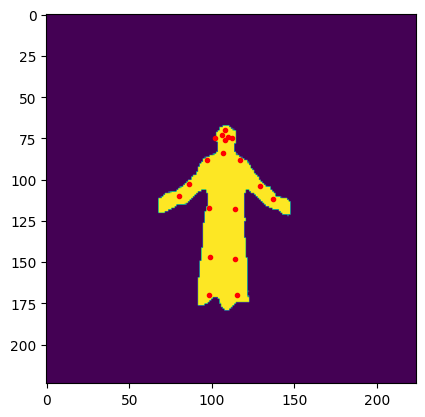

In [9]:
plt.imshow(mask_scaled_f)
for i in range(len(joints_f)):
  plt.plot(joints_f[i][0], joints_f[i][1], marker='.', color="red")
plt.show()

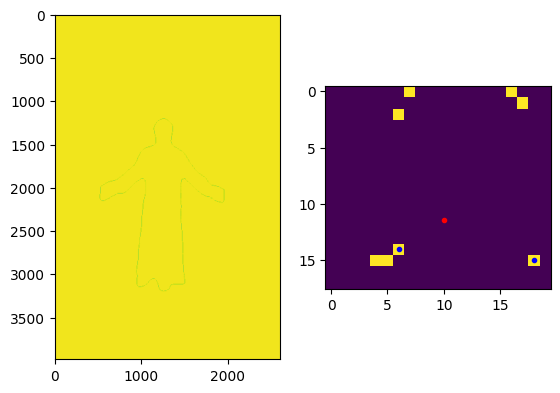

In [10]:
dest_f = corner_detection(mask_f)
dest_scaled_f = preprocess_gray(dest_f)
dest_crop_f = dest_scaled_f[joints_f[13][1]:int((joints_f[8][1]+joints_f[9][1])/2),joints_f[8][0]:joints_f[9][0]]
# dest_crop_f = dest_scaled_f[top_f:int((joints_f[8][1]+joints_f[9][1])/2),joints_f[8][0]:joints_f[9][0]]
norm_f = abs(dest_crop_f)>0
r_neck_f,l_neck_f = shortest_neck(norm_f,[shifted_neck_f[0]-joints_f[8][0], shifted_neck_f[1]-joints_f[13][1]])
# r_neck_f,l_neck_f = shortest_neck(norm_f,[shifted_neck_f[0]-joints_f[8][0], shifted_neck_f[1]-top_f])
plt.subplot(121)
plt.imshow(dest_f)
plt.subplot(122)
plt.imshow(norm_f)
plt.plot(shifted_neck_f[0]-joints_f[8][0], shifted_neck_f[1]-joints_f[13][1], marker='.', color="red") 
# plt.plot(shifted_neck_f[0]-joints_f[8][0], shifted_neck_f[1]-top_f, marker='.', color="red") 
plt.plot(r_neck_f[1],r_neck_f[0],marker = ".", color = 'blue')
plt.plot(l_neck_f[1],l_neck_f[0],marker = ".", color = 'blue')
plt.show()

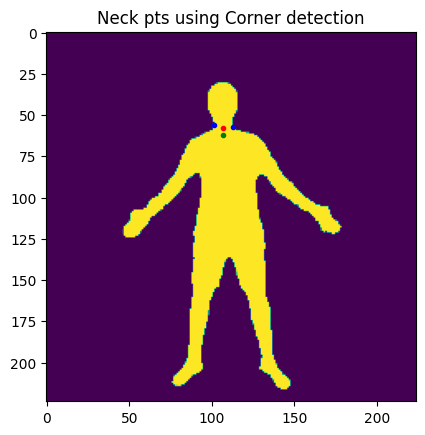

In [14]:
r_neck_scaled_f = [r_neck_f[1]+joints_f[8][0],r_neck_f[0]+joints_f[13][1]]
l_neck_scaled_f = [l_neck_f[1]+joints_f[8][0],l_neck_f[0]+joints_f[13][1]] 
plt.imshow(mask_scaled_f)
plt.title('Neck pts using Corner detection')
plt.plot(r_neck_scaled_f[0],r_neck_scaled_f[1],marker = ".", color = 'blue')
plt.plot(l_neck_scaled_f[0],l_neck_scaled_f[1],marker = ".", color = 'blue')
plt.plot(joints_f[12][0], joints_f[12][1],marker = ".", color = 'green')
plt.plot(shifted_neck_f[0], shifted_neck_f[1], marker='.', color="red")
plt.show()

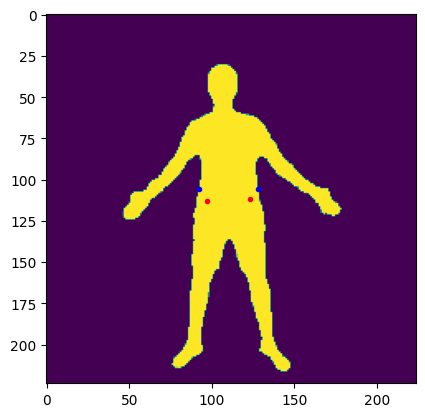

In [15]:
shifted_waist_f = shift_waist(joints_f, ht_p_f, waist_shift_factor)
r_waist_f,l_waist_f = waist_pts(mask_scaled_f,shifted_waist_f)
plt.imshow(mask_scaled_f)
plt.plot(r_waist_f,shifted_waist_f[1], marker='.', color="blue")
plt.plot(l_waist_f,shifted_waist_f[1], marker='.', color="blue")
for i in [2,3]:
  plt.plot(joints_f[i][0], joints_f[i][1], marker='.', color="red")
plt.show()

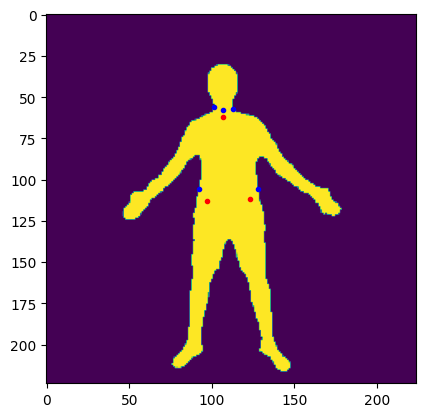

In [16]:
plt.imshow(mask_scaled_f)
plt.plot(r_waist_f,shifted_waist_f[1], marker='.', color="blue")
plt.plot(l_waist_f,shifted_waist_f[1], marker='.', color="blue")
plt.plot(r_neck_scaled_f[0],r_neck_scaled_f[1],marker = ".", color = 'blue')
plt.plot(l_neck_scaled_f[0],l_neck_scaled_f[1],marker = ".", color = 'blue')
plt.plot(joints_f[12][0], joints_f[12][1],marker = ".", color = 'red')
plt.plot(shifted_neck_f[0], shifted_neck_f[1], marker='.', color="blue")
for i in [2,3]:
  plt.plot(joints_f[i][0], joints_f[i][1], marker='.', color="red")
plt.show()
r_waist_f = [r_waist_f,shifted_waist_f[1]]
l_waist_f = [l_waist_f,shifted_waist_f[1]]

### Side View

In [18]:
side_image = Image.open(side_img_dir)
res_im,seg_s=seg_model.run(side_image)
mask_s, bg_removed_s = bg_removal(side_image, seg_s)

In [19]:
ori_s, inp_s, param_s = preprocess_image("..\\..\\out\\bg_rem_img.jpg",224)
joints_s, vertices_s, cams_s = hmr(inp_s, hmr_model)

Resizing image to 224


In [20]:
# mesh = renderer.mesh(vertices_s[0])
# mesh.show()

In [16]:
# visualize(renderer, np.array(side_image), param_s, vertices_s[0], cams_s[0], joints_s[0])

In [21]:
joints_s = joints_s[0]
img_s, joints_s = convert_to_int(inp_s, joints_s)

In [22]:
mask_scaled_s = preprocess_gray(mask_s)
top_s, bottom_s  = ht_pts(mask_scaled_s,ht_factor)
ht_p_s = (max(joints_s[0][1],joints_s[5][1])) - top_s
shifted_neck_s = shift_neck(joints_s, neck_shift_factor, ht_p_s)
mask_crop_s = mask_scaled_s[top_s:int((joints_s[8][1]+joints_s[9][1])/2),int(joints_s[8][0]-ht_p_s*0.05):int(joints_s[9][0]+ht_p_s*0.05)]

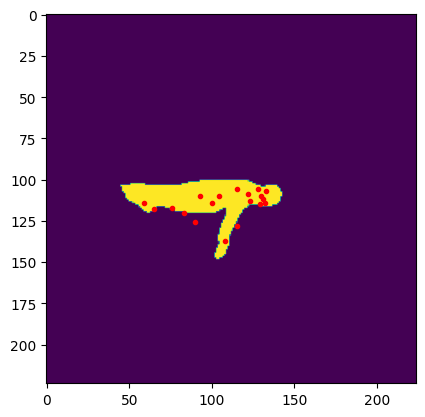

In [24]:
plt.imshow(mask_scaled_s)
for i in range(len(joints_s)):
  plt.plot(joints_s[i][0], joints_s[i][1], marker='.', color="red")
plt.show()

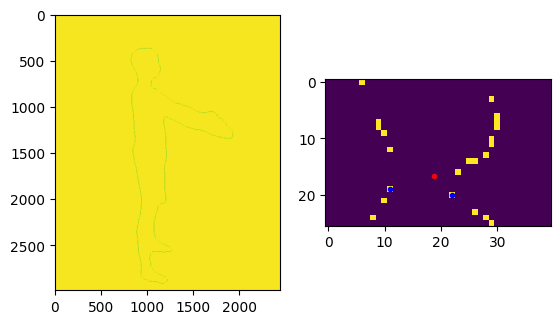

In [19]:
dest_s = corner_detection(mask_s)
dest_scaled_s = preprocess_gray(dest_s)
dest_crop_s = dest_scaled_s[joints_s[13][1]:int((joints_s[8][1]+joints_s[9][1])/2),int(joints_s[8][0]-ht_p_s*0.1):int(joints_s[9][0]+ht_p_s*0.1)]
norm_s = abs(dest_crop_s)>0
r_neck_s,l_neck_s = shortest_neck(norm_s,[joints_s[12][0]-joints_s[8][0]+ht_p_s*0.1, joints_s[12][1]-ht_p_s*neck_shift_factor-joints_s[13][1]])
plt.subplot(121)
plt.imshow(dest_s)
plt.subplot(122)
plt.imshow(norm_s)
plt.plot(joints_s[12][0]-joints_s[8][0]+ht_p_s*0.1, joints_s[12][1]-ht_p_s*neck_shift_factor-joints_s[13][1], marker='.', color="red") 
plt.plot(r_neck_s[1],r_neck_s[0],marker = ".", color = 'blue')
plt.plot(l_neck_s[1],l_neck_s[0],marker = ".", color = 'blue')
plt.show()

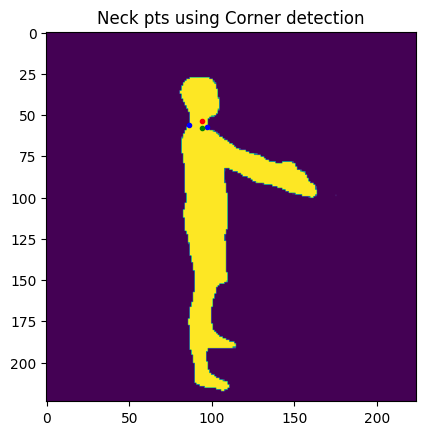

In [20]:
r_neck_scaled_s = [r_neck_s[1]+joints_s[8][0]-ht_p_s*0.1,r_neck_s[0]+joints_s[13][1]]
l_neck_scaled_s = [l_neck_s[1]+joints_s[8][0]-ht_p_s*0.1,l_neck_s[0]+joints_s[13][1]]
plt.imshow(mask_scaled_s)
plt.title('Neck pts using Corner detection')
plt.plot(r_neck_scaled_s[0],r_neck_scaled_s[1],marker = ".", color = 'blue')
plt.plot(l_neck_scaled_s[0],l_neck_scaled_s[1],marker = ".", color = 'blue')
plt.plot(joints_s[12][0], joints_s[12][1],marker = ".", color = 'green')
plt.plot(shifted_neck_s[0], shifted_neck_s[1], marker='.', color="red")
plt.show()

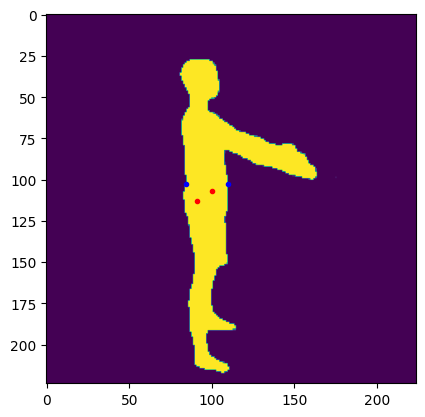

In [21]:
shifted_waist_s = shift_waist(joints_s, ht_p_s, waist_shift_factor)
r_waist_s,l_waist_s = waist_pts(mask_scaled_s,shifted_waist_s)
plt.imshow(mask_scaled_s)
plt.plot(r_waist_s,shifted_waist_s[1], marker='.', color="blue")
plt.plot(l_waist_s,shifted_waist_s[1], marker='.', color="blue")
for i in [2,3]:
  plt.plot(joints_s[i][0], joints_s[i][1], marker='.', color="red")
plt.show()

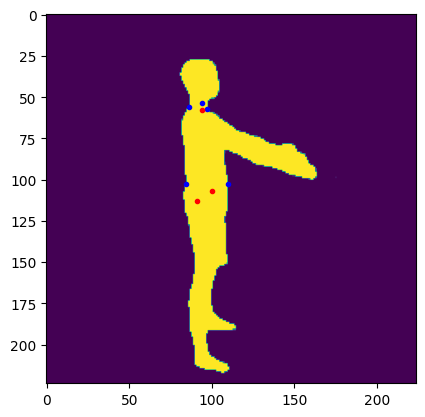

In [22]:
plt.imshow(mask_scaled_s)
plt.plot(r_waist_s,shifted_waist_s[1], marker='.', color="blue")
plt.plot(l_waist_s,shifted_waist_s[1], marker='.', color="blue")
plt.plot(r_neck_scaled_s[0],r_neck_scaled_s[1],marker = ".", color = 'blue')
plt.plot(l_neck_scaled_s[0],l_neck_scaled_s[1],marker = ".", color = 'blue')
plt.plot(joints_s[12][0], joints_s[12][1],marker = ".", color = 'red')
plt.plot(shifted_neck_s[0], shifted_neck_s[1], marker='.', color="blue")
for i in [2,3]:
  plt.plot(joints_s[i][0], joints_s[i][1], marker='.', color="red")
plt.show()
r_waist_s = [r_waist_s,shifted_waist_s[1]]
l_waist_s = [l_waist_s,shifted_waist_s[1]]

### Hand Tracking

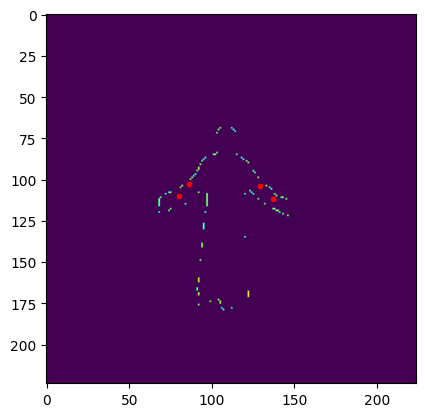

In [11]:
plt.imshow(abs(dest_scaled_f)>0)
for i in [6,7,10,11]:
  plt.plot(joints_f[i][0], joints_f[i][1], marker='.', color="red")
plt.show()

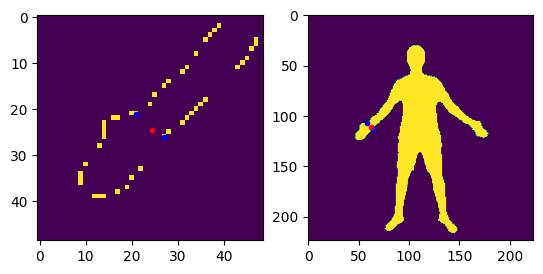

In [25]:
hand_crop_r = (abs(dest_scaled_f)>0)[int(joints_f[6][1]-ht_p_f * 0.15):int(joints_f[6][1]+ht_p_f * 0.15), int(joints_f[6][0]-ht_p_f * 0.15):int(joints_f[6][0]+ht_p_f * 0.15)]
shifted_hand_r = np.array([ht_p_f * 0.15,ht_p_f * 0.15]) 
r,l = shortest_hand_right(hand_crop_r, shifted_hand_r)
right_wrist_r = np.array([r[1]+joints_f[6][0]-ht_p_f * 0.15,r[0]+joints_f[6][1]-ht_p_f * 0.15])
right_wrist_l = np.array([l[1]+joints_f[6][0]-ht_p_f * 0.15,l[0]+joints_f[6][1]-ht_p_f * 0.15])
plt.subplot(121)
plt.imshow(hand_crop_r)
plt.plot(r[1],r[0],marker='.',color = 'blue')
plt.plot(l[1],l[0],marker='.',color = 'blue')
plt.plot(shifted_hand_r[0],shifted_hand_r[1],marker='.',color = 'red')
plt.subplot(122)
plt.imshow(mask_scaled_f)
plt.plot(right_wrist_r[0],right_wrist_r[1],marker='.',color = 'blue')
plt.plot(right_wrist_l[0],right_wrist_l[1],marker='.',color = 'blue')
plt.plot(joints_f[6][0], joints_f[6][1], marker='.', color="red")
plt.show()

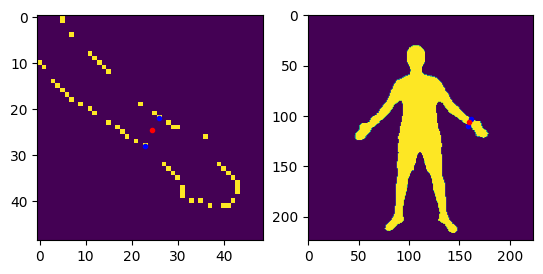

In [26]:
hand_crop_l = (abs(dest_scaled_f)>0)[int(joints_f[11][1]-ht_p_f * 0.15):int(joints_f[11][1]+ht_p_f * 0.15), int(joints_f[11][0]-ht_p_f * 0.15):int(joints_f[11][0]+ht_p_f * 0.15)]
shifted_hand_l = np.array([ht_p_f * 0.15,ht_p_f * 0.15]) 
r,l = shortest_hand_left(hand_crop_l, shifted_hand_l)
left_wrist_r = np.array([r[1]+joints_f[11][0]-ht_p_f * 0.15,r[0]+joints_f[11][1]-ht_p_f * 0.15])
left_wrist_l = np.array([l[1]+joints_f[11][0]-ht_p_f * 0.15,l[0]+joints_f[11][1]-ht_p_f * 0.15])
plt.subplot(121)
plt.imshow(hand_crop_l)
plt.plot(r[1],r[0],marker='.',color = 'blue')
plt.plot(l[1],l[0],marker='.',color = 'blue')
plt.plot(shifted_hand_r[0],shifted_hand_r[1],marker='.',color = 'red')
plt.subplot(122)
plt.imshow(mask_scaled_f)
plt.plot(left_wrist_r[0],left_wrist_r[1],marker='.',color = 'blue')
plt.plot(left_wrist_l[0],left_wrist_l[1],marker='.',color = 'blue')
plt.plot(joints_f[11][0], joints_f[11][1], marker='.', color="red")
plt.show()

### Final feature points

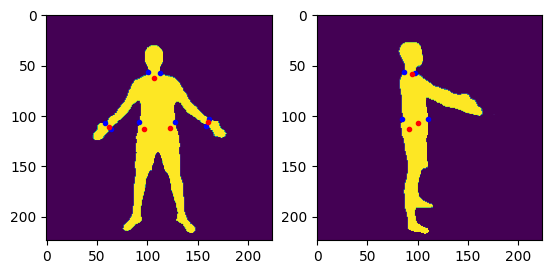

In [27]:
plt.subplot(121)
plt.imshow(mask_scaled_f)
plt.plot(r_waist_f[0],r_waist_f[1], marker='.', color="blue")
plt.plot(l_waist_f[0],l_waist_f[1], marker='.', color="blue")
plt.plot(r_neck_scaled_f[0],r_neck_scaled_f[1],marker = ".", color = 'blue')
plt.plot(l_neck_scaled_f[0],l_neck_scaled_f[1],marker = ".", color = 'blue')
plt.plot(joints_f[12][0], joints_f[12][1],marker = ".", color = 'red')
plt.plot(left_wrist_r[0],left_wrist_r[1],marker='.',color = 'blue')
plt.plot(left_wrist_l[0],left_wrist_l[1],marker='.',color = 'blue')
plt.plot(right_wrist_r[0],right_wrist_r[1],marker='.',color = 'blue')
plt.plot(right_wrist_l[0],right_wrist_l[1],marker='.',color = 'blue')
for i in [2,3,6,11]:
  plt.plot(joints_f[i][0], joints_f[i][1], marker='.', color="red")

plt.subplot(122)
plt.imshow(mask_scaled_s)
plt.plot(r_waist_s[0],r_waist_s[1], marker='.', color="blue")
plt.plot(l_waist_s[0],l_waist_s[1], marker='.', color="blue")
plt.plot(r_neck_scaled_s[0],r_neck_scaled_s[1],marker = ".", color = 'blue')
plt.plot(l_neck_scaled_s[0],l_neck_scaled_s[1],marker = ".", color = 'blue')
plt.plot(joints_s[12][0], joints_s[12][1],marker = ".", color = 'red')
for i in [2,3]:
  plt.plot(joints_s[i][0], joints_s[i][1], marker='.', color="red")
plt.show()

### Measurement

In [28]:
print("Height in pixels in front view: "+ str(ht_p_f))
print("Height in pixels in side view: "+ str(ht_p_s))
lpp_f = ht / ht_p_f
lpp_s = ht / ht_p_s
print("Length per pixel in front image (in cm): "+str(lpp_f))
print("Length per pixel in side image (in cm): "+str(lpp_s))

Height in pixels in front view: 163.5
Height in pixels in side view: 177
Length per pixel in front image (in cm): 1.1009174311926606
Length per pixel in side image (in cm): 1.0169491525423728


In [29]:
cuff = (dist(right_wrist_r[0],right_wrist_r[1],right_wrist_l[0],right_wrist_l[1]) + dist(left_wrist_r[0],left_wrist_r[1],left_wrist_l[0],left_wrist_l[1]))/2 * lpp_f
cuff_c = cuff * wrist_factor

In [30]:
print("Height: "+str(ht)+" cm")
waist_f, neck_f = front_measurement(joints_f, r_waist_f, l_waist_f, r_neck_scaled_f, l_neck_scaled_f, lpp_f, arm_scale)
waist_s, neck_s = side_measurement(joints_s, r_waist_s, l_waist_s, r_neck_scaled_s, l_neck_scaled_s, lpp_s)
circumference("Waist", waist_f/2, waist_s/2)
circumference("Neck", neck_f/2, neck_s/2)
print("Wrist Front width: "+str(cuff)+ " cm")
print("Cuff cirumference: "+str(cuff_c)+ " cm")

Height: 180 cm
Shoulder: 33.10083606247246 cm
Arm: 56.35861409908306 cm
Waist Front: 39.633027522935784 cm
Neck Front: 13.256801371147482 cm
Waist Side: 26.440677966101696 cm
Neck Side: 11.232570525953147 cm
Waist circumference: 105.8367662658156 cm
Neck circumference: 38.59897030172679 cm
Wrist Front width: 7.991809325728084 cm
Cuff cirumference: 17.581980516601785 cm


To check: pose of user, pose estimation alternatives

#### Using Edge detection

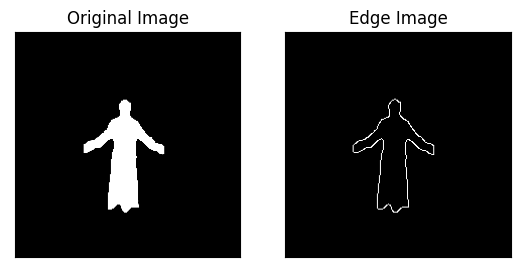

In [12]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = mask_scaled_f
edges = cv.Canny(img,224,224)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

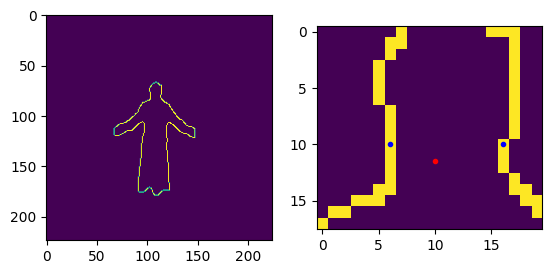

In [13]:
dest_f = corner_detection(mask_f)
dest_scaled_f = edges
dest_crop_f = dest_scaled_f[joints_f[13][1]:int((joints_f[8][1]+joints_f[9][1])/2),joints_f[8][0]:joints_f[9][0]]
# dest_crop_f = dest_scaled_f[top_f:int((joints_f[8][1]+joints_f[9][1])/2),joints_f[8][0]:joints_f[9][0]]
norm_f = abs(dest_crop_f)>0
r_neck_f,l_neck_f = shortest_neck(norm_f,[shifted_neck_f[0]-joints_f[8][0],shifted_neck_f[1]-joints_f[13][1]])
# r_neck_f,l_neck_f = shortest_neck(norm_f,[shifted_neck_f[0]-joints_f[8][0], shifted_neck_f[1]-top_f])
plt.subplot(121)
plt.imshow(edges)
plt.subplot(122)
plt.imshow(norm_f)
plt.plot(shifted_neck_f[0]-joints_f[8][0], shifted_neck_f[1]-joints_f[13][1], marker='.', color="red") 
# plt.plot(shifted_neck_f[0]-joints_f[8][0], shifted_neck_f[1]-top_f, marker='.', color="red") 
plt.plot(r_neck_f[1],r_neck_f[0],marker = ".", color = 'blue')
plt.plot(l_neck_f[1],l_neck_f[0],marker = ".", color = 'blue')
plt.show()

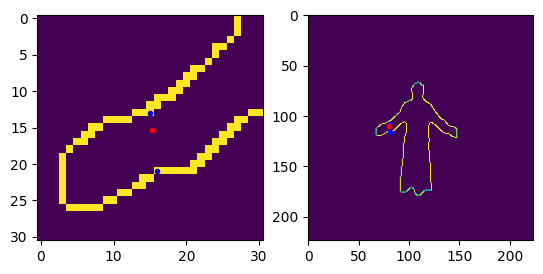

In [14]:
hand_crop_r = (edges)[int(joints_f[6][1]-ht_p_f * 0.15):int(joints_f[6][1]+ht_p_f * 0.15), int(joints_f[6][0]-ht_p_f * 0.15):int(joints_f[6][0]+ht_p_f * 0.15)]
shifted_hand_r = np.array([ht_p_f * 0.15,ht_p_f * 0.15]) 
r,l = shortest_hand_right(hand_crop_r, shifted_hand_r)
right_wrist_r = np.array([r[1]+joints_f[6][0]-ht_p_f * 0.15,r[0]+joints_f[6][1]-ht_p_f * 0.15])
right_wrist_l = np.array([l[1]+joints_f[6][0]-ht_p_f * 0.15,l[0]+joints_f[6][1]-ht_p_f * 0.15])
plt.subplot(121)
plt.imshow(hand_crop_r)
plt.plot(r[1],r[0],marker='.',color = 'blue')
plt.plot(l[1],l[0],marker='.',color = 'blue')
plt.plot(shifted_hand_r[0],shifted_hand_r[1],marker='.',color = 'red')
plt.subplot(122)
plt.imshow(edges)
plt.plot(right_wrist_r[0],right_wrist_r[1],marker='.',color = 'blue')
plt.plot(right_wrist_l[0],right_wrist_l[1],marker='.',color = 'blue')
plt.plot(joints_f[6][0], joints_f[6][1], marker='.', color="red")
plt.show()

ipykernel_launcher:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


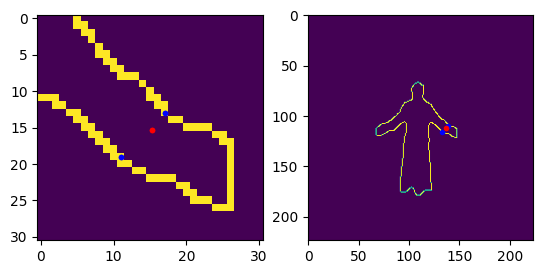

In [16]:
hand_crop_l = (edges>150)[int(joints_f[11][1]-ht_p_f * 0.15):int(joints_f[11][1]+ht_p_f * 0.15), int(joints_f[11][0]-ht_p_f * 0.15):int(joints_f[11][0]+ht_p_f * 0.15)]
shifted_hand_l = np.array([ht_p_f * 0.15,ht_p_f * 0.15]) 
r,l = shortest_hand_left(hand_crop_l, shifted_hand_l)
left_wrist_r = np.array([r[1]+joints_f[11][0]-ht_p_f * 0.15,r[0]+joints_f[11][1]-ht_p_f * 0.15])
left_wrist_l = np.array([l[1]+joints_f[11][0]-ht_p_f * 0.15,l[0]+joints_f[11][1]-ht_p_f * 0.15])
plt.subplot(121)
plt.imshow(hand_crop_l)
plt.plot(r[1],r[0],marker='.',color = 'blue')
plt.plot(l[1],l[0],marker='.',color = 'blue')
plt.plot(shifted_hand_r[0],shifted_hand_r[1],marker='.',color = 'red')
plt.subplot(122)
plt.imshow(edges)
plt.plot(left_wrist_r[0],left_wrist_r[1],marker='.',color = 'blue')
plt.plot(left_wrist_l[0],left_wrist_l[1],marker='.',color = 'blue')
plt.plot(joints_f[11][0], joints_f[11][1], marker='.', color="red")
plt.show()

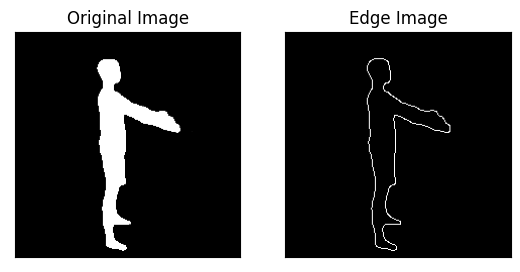

In [35]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = mask_scaled_s
edges = cv.Canny(img,224,224)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

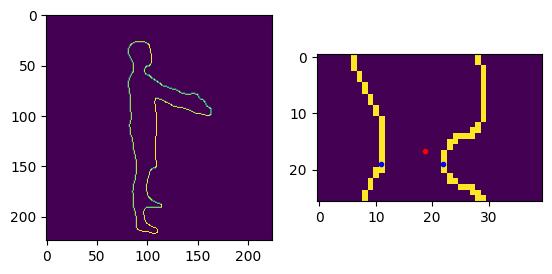

In [36]:
dest_scaled_s = edges
dest_crop_s = dest_scaled_s[joints_s[13][1]:int((joints_s[8][1]+joints_s[9][1])/2),int(joints_s[8][0]-ht_p_s*0.1):int(joints_s[9][0]+ht_p_s*0.1)]
norm_s = abs(dest_crop_s)>0
r_neck_s,l_neck_s = shortest_neck(norm_s,[joints_s[12][0]-joints_s[8][0]+ht_p_s*0.1, joints_s[12][1]-ht_p_s*neck_shift_factor-joints_s[13][1]])
plt.subplot(121)
plt.imshow(edges)
plt.subplot(122)
plt.imshow(norm_s)
plt.plot(joints_s[12][0]-joints_s[8][0]+ht_p_s*0.1, joints_s[12][1]-ht_p_s*neck_shift_factor-joints_s[13][1], marker='.', color="red") 
plt.plot(r_neck_s[1],r_neck_s[0],marker = ".", color = 'blue')
plt.plot(l_neck_s[1],l_neck_s[0],marker = ".", color = 'blue')
plt.show()